## 1. Setup
- Install/import libraries
- Set seeds
- GPU check

In [37]:
# If needed, install extras (uncomment)
# %pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
# %pip install pandas numpy matplotlib scikit-learn tqdm

import json
import math
import os
import random
from collections import Counter, defaultdict
from pathlib import Path
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.backends.cudnn.benchmark = torch.cuda.is_available()

Using device: cpu


## 2. Load CUAD Dataset
Assumes CUAD v1 JSON files are in `data/cuad/`.
- `CUAD_v1.json` (contracts)
- `CUAD_v1_questions.json` (41 clause types)
- `CUAD_v1_annotations.json` (labels)

In [47]:
from pathlib import Path
from typing import Tuple, List, Dict
from collections import defaultdict
import json
import pandas as pd
import numpy as np
import re

DATA_DIR = Path(r'CUAD_v1')
TXT_DIR = DATA_DIR / 'full_contract_txt'
CONTRACTS_PATH = DATA_DIR / 'CUAD_v1.json'
QUESTIONS_PATH = DATA_DIR / 'CUAD_v1_questions.json'
ANNOTATIONS_PATH = DATA_DIR / 'CUAD_v1_annotations.json'


def ensure_file(path: Path, hint: str):
    if not path.exists():
        raise FileNotFoundError(f"Missing required file: {path}. {hint}")


def load_json(path: Path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)


def load_txt_map(txt_dir: Path) -> Dict[str, str]:
    """Load TXT files with normalized keys for fallback."""
    mapping = {}
    if not txt_dir.exists():
        print(f"Warning: TXT directory not found: {txt_dir}")
        return mapping
    for p in txt_dir.glob('*.txt'):
        try:
            # Normalize the key for matching
            normalized_key = normalize_doc_id(p.stem)
            mapping[normalized_key] = p.read_text(encoding='utf-8', errors='ignore')
        except Exception as exc:
            print(f"Could not read {p.name}: {exc}")
    print(f"Loaded {len(mapping)} TXT files from {txt_dir}")
    return mapping


def normalize_doc_id(raw: str) -> str:
    """Normalize a filename/doc_id for matching.
    Removes: spaces, punctuation, PDF extension, special chars.
    Converts to lowercase for case-insensitive matching.
    """
    if not raw:
        return ''
    # Remove .pdf extension if present
    stem = Path(raw).stem
    # Remove common punctuation and special characters
    stem = re.sub(r'[_\-\s.,()\'\"]+', '', stem)
    # Lowercase for case-insensitive matching
    return stem.lower()


def get_contract_text(contract: Dict, txt_lookup: Dict[str, str]) -> str:
    """Extract full contract text from SQuAD-style paragraphs or TXT fallback."""
    # CUAD v1 stores contracts in SQuAD format: data[i]['paragraphs'][j]['context']
    paragraphs = contract.get('paragraphs', [])
    if paragraphs:
        # Extract context from each paragraph
        texts = [p.get('context', '') for p in paragraphs if 'context' in p]
        combined = '\n\n'.join(texts)  # Join with paragraph breaks
        if combined.strip():
            return combined
    
    # Fallback to TXT lookup with normalized title/doc_id
    title = contract.get('title', '') or contract.get('doc_id', '') or contract.get('id', '')
    normalized = normalize_doc_id(title)
    text = txt_lookup.get(normalized, '')
    return text


def load_master_clauses(csv_path: Path) -> Tuple[List[str], Dict[str, List[int]]]:
    """Use master_clauses.csv as a label source when official Q/A files are missing."""
    df_csv = pd.read_csv(csv_path)
    meta_cols = {'Filename', 'Document Name', 'Document Name-Answer'}
    base_labels: List[str] = []
    for col in df_csv.columns:
        if col.endswith('-Answer'):
            continue
        if col in meta_cols:
            continue
        base_labels.append(col.strip())
    label_to_idx = {l: i for i, l in enumerate(base_labels)}
    doc_to_labels: Dict[str, List[int]] = defaultdict(lambda: [0] * len(base_labels))

    def is_positive(val) -> bool:
        if pd.isna(val):
            return False
        s = str(val).strip()
        if s in ('', '[]', 'No', 'no', 'none', 'None'):
            return False
        return True

    for _, row in df_csv.iterrows():
        # Get filename and normalize it
        raw_filename = row.get('Filename') or row.get('Document Name') or ''
        normalized_key = normalize_doc_id(raw_filename)
        
        labels_vec = [0] * len(base_labels)
        for lbl in base_labels:
            base_val = row.get(lbl)
            ans_val = row.get(f"{lbl}-Answer") if f"{lbl}-Answer" in row else None
            labels_vec[label_to_idx[lbl]] = 1 if (is_positive(base_val) or is_positive(ans_val)) else 0
        doc_to_labels[normalized_key] = labels_vec

    print(f"Loaded master_clauses.csv with {len(base_labels)} labels and {len(doc_to_labels)} rows")
    return base_labels, doc_to_labels


def create_questions_json(clause_labels: List[str], output_path: Path):
    """Create CUAD_v1_questions.json from clause labels."""
    questions = []
    for idx, label in enumerate(clause_labels):
        questions.append({
            "question_id": idx,
            "question_text": label
        })
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(questions, f, indent=2)
    print(f"Created {output_path} with {len(questions)} questions")


def create_annotations_json(doc_to_labels: Dict[str, List[int]], clause_labels: List[str], 
                           contracts_json: Dict, output_path: Path):
    """Create CUAD_v1_annotations.json from doc_to_labels mapping."""
    annotations = []
    
    # Get contracts list
    contracts = contracts_json.get('data', []) if isinstance(contracts_json, dict) else contracts_json
    
    for contract in contracts:
        title = contract.get('title', '') or contract.get('doc_id', '') or contract.get('id', '')
        normalized_title = normalize_doc_id(title)
        
        # Get labels for this document
        labels = doc_to_labels.get(normalized_title)
        if labels:
            # Create annotation for each positive label
            for idx, is_positive in enumerate(labels):
                if is_positive == 1:
                    annotations.append({
                        "doc_id": title,  # Use original title, not normalized
                        "question_text": clause_labels[idx]
                    })
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(annotations, f, indent=2)
    print(f"Created {output_path} with {len(annotations)} annotations")


def infer_from_squad_style(contracts_json: Dict) -> Tuple[List[str], Dict[str, List[int]]]:
    """Fallback: infer clause labels and doc->labels from SQuAD-style CUAD_v1.json when questions/annotations JSONs are missing."""
    data = contracts_json.get('data', []) if isinstance(contracts_json, dict) else contracts_json
    label_set = []
    doc_to_labels = defaultdict(list)
    
    # Collect all unique question types
    for item in data:
        paragraphs = item.get('paragraphs', []) if isinstance(item, dict) else []
        for par in paragraphs:
            for qa in par.get('qas', []):
                qtext = qa.get('question') or qa.get('question_text')
                if qtext and qtext not in label_set:
                    label_set.append(qtext)
    
    clause_labels = label_set
    num_labels = len(clause_labels)
    label_to_idx = {l: i for i, l in enumerate(clause_labels)}
    
    # Assign labels per document
    for item in data:
        doc_id = item.get('title') or item.get('doc_id') or item.get('id') or ''
        multi = [0] * num_labels
        paragraphs = item.get('paragraphs', []) if isinstance(item, dict) else []
        for par in paragraphs:
            for qa in par.get('qas', []):
                qtext = qa.get('question') or qa.get('question_text')
                if qtext in label_to_idx:
                    is_impossible = qa.get('is_impossible', False)
                    has_answer = bool(qa.get('answers')) and not is_impossible
                    multi[label_to_idx[qtext]] = 1 if has_answer else multi[label_to_idx[qtext]]
        doc_to_labels[doc_id] = multi
    
    return clause_labels, doc_to_labels


# Ensure base file exists
ensure_file(CONTRACTS_PATH, "Expected CUAD_v1.json in CUAD_v1 folder.")
contracts_json = load_json(CONTRACTS_PATH)

# Try to load questions/annotations if present; otherwise fall back to CUAD_v1.json content
questions = None
annotations = None
if QUESTIONS_PATH.exists():
    questions = load_json(QUESTIONS_PATH)
if ANNOTATIONS_PATH.exists():
    annotations = load_json(ANNOTATIONS_PATH)
MASTER_CLAUSES_PATH = DATA_DIR / 'master_clauses.csv'

if questions is not None and annotations is not None:
    clause_labels = [q['question_text'] for q in questions]
    label_to_idx = {label: i for i, label in enumerate(clause_labels)}
    num_labels = len(clause_labels)
    print('Num labels (from questions file):', num_labels)

    doc_to_labels: Dict[str, List[int]] = defaultdict(lambda: [0] * num_labels)
    for ann in annotations:
        doc_id = ann['doc_id']
        q_text = ann['question_text']
        if q_text not in label_to_idx:
            continue
        doc_to_labels[doc_id][label_to_idx[q_text]] = 1
elif MASTER_CLAUSES_PATH.exists():
    print("questions/annotations JSON not found — using master_clauses.csv as label source.")
    clause_labels, doc_to_labels = load_master_clauses(MASTER_CLAUSES_PATH)
    num_labels = len(clause_labels)
    print('Num labels (master_clauses):', num_labels)
    
    # Create the missing JSON files for future use
    print("\nCreating CUAD_v1_questions.json and CUAD_v1_annotations.json from CSV data...")
    create_questions_json(clause_labels, QUESTIONS_PATH)
    create_annotations_json(doc_to_labels, clause_labels, contracts_json, ANNOTATIONS_PATH)
    print("✓ JSON files created successfully!")
else:
    print("questions/annotations JSON not found — falling back to infer labels from CUAD_v1.json (SQuAD-style).")
    clause_labels, doc_to_labels = infer_from_squad_style(contracts_json)
    num_labels = len(clause_labels)
    print('Num labels (inferred):', num_labels)

# Contracts list handling: if squad-style dict, unwrap data; else assume list
if isinstance(contracts_json, dict) and 'data' in contracts_json:
    contracts = contracts_json['data']
else:
    contracts = contracts_json

# Load TXT files as fallback (with normalized keys)
txt_lookup = load_txt_map(TXT_DIR)

print(f'Contracts: {len(contracts)} | Labels available: {num_labels}')

records = []
missing_text = 0
unmatched_labels = 0
for c in contracts:
    # Get doc_id from title field (standard in CUAD v1)
    doc_id = c.get('title', '') or c.get('doc_id', '') or c.get('id', '')
    text = get_contract_text(c, txt_lookup)
    if not text:
        missing_text += 1
    
    # Normalize the doc_id for label lookup
    normalized_id = normalize_doc_id(doc_id)
    labels = doc_to_labels.get(normalized_id, None)
    
    if labels is None:
        labels = [0] * num_labels
        unmatched_labels += 1
    
    records.append({'doc_id': doc_id, 'text': text, 'labels': labels})

if missing_text:
    print(f"Warning: {missing_text} contracts missing text after TXT fallback")
if unmatched_labels:
    print(f"Warning: {unmatched_labels} contracts missing labels after lookup")

clause_labels = clause_labels  # keep name stable
label_to_idx = {label: i for i, label in enumerate(clause_labels)}
df = pd.DataFrame(records)
print(df.head())
print('Label density (avg positives per doc):', np.mean([sum(l) for l in df.labels]))

questions/annotations JSON not found — using master_clauses.csv as label source.
Loaded master_clauses.csv with 41 labels and 510 rows
Num labels (master_clauses): 41

Creating CUAD_v1_questions.json and CUAD_v1_annotations.json from CSV data...
Created CUAD_v1\CUAD_v1_questions.json with 41 questions
Created CUAD_v1\CUAD_v1_annotations.json with 608 annotations
✓ JSON files created successfully!
Loaded 478 TXT files from CUAD_v1\full_contract_txt
Contracts: 510 | Labels available: 41
                                              doc_id  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1  WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...   
2  LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...   
3  CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...   
4   NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT   

                                                text  \
0  EXHIBIT 10.6\n\n                              ...   
1  Exhibit 10.26    CONFIDENTIAL TREATMENT HAS BE...   
2  Ex

## 3. Head–Tail Sampling Function
Take first 1000 and last 1000 words, insert `[HT_SPLIT]`.

In [39]:
HT_SPLIT = '[HT_SPLIT]'
HEAD_N = 1000
TAIL_N = 1000
MAX_SEQ_WORDS = HEAD_N + TAIL_N + 1  # include split token

def simple_word_tokenize(text: str) -> List[str]:
    return text.split()

def head_tail_sample(text: str) -> List[str]:
    tokens = simple_word_tokenize(text)
    head = tokens[:HEAD_N]
    tail = tokens[-TAIL_N:] if len(tokens) >= TAIL_N else tokens[-len(tokens):]
    return head + [HT_SPLIT] + tail

# Preview on first contract
sample_tokens = head_tail_sample(df.iloc[0].text)
print('Sample length:', len(sample_tokens))
print('Snippet:', ' '.join(sample_tokens[:30]), '...')

Sample length: 2001
Snippet: EXHIBIT 10.6 DISTRIBUTOR AGREEMENT THIS DISTRIBUTOR AGREEMENT (the "Agreement") is made by and between Electric City Corp., a Delaware corporation ("Company") and Electric City of Illinois LLC ("Distributor") this 7th ...


## 4. Tokenization + Numerical Encoding
Build vocab from scratch and encode text; pad/truncate sequences.

In [40]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
VOCAB_MIN_FREQ = 2
MAX_SEQ_LEN = 2000 + 1  # should match MAX_SEQ_WORDS but kept explicit

def build_vocab(tokenized_texts: List[List[str]], min_freq: int = VOCAB_MIN_FREQ) -> Dict[str, int]:
    counter = Counter()
    for toks in tokenized_texts:
        counter.update(toks)
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for tok, freq in counter.items():
        if freq >= min_freq and tok not in vocab:
            vocab[tok] = len(vocab)
    return vocab

def encode_tokens(tokens: List[str], vocab: Dict[str, int], max_len: int = MAX_SEQ_LEN) -> List[int]:
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids

# Build tokenized corpus
df['tokens'] = df.text.apply(head_tail_sample)
vocab = build_vocab(df.tokens.tolist(), min_freq=VOCAB_MIN_FREQ)
vocab_size = len(vocab)
print('Vocab size:', vocab_size)

df['input_ids'] = df.tokens.apply(lambda t: encode_tokens(t, vocab, MAX_SEQ_LEN))
print('Encoded example length:', len(df.iloc[0].input_ids))

Vocab size: 30060
Encoded example length: 2001


## 5. Dataset + DataLoader
Custom dataset, 70/15/15 split, DataLoaders.

In [41]:
class CuadDataset(Dataset):
    def __init__(self, df_slice: pd.DataFrame):
        self.inputs = df_slice.input_ids.tolist()
        self.labels = df_slice.labels.tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.float)
        return x, y

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, shuffle=True)

BATCH_SIZE = 8

train_loader = DataLoader(CuadDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(CuadDataset(val_df), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(CuadDataset(test_df), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

len(train_loader), len(val_loader), len(test_loader)

(45, 10, 10)

## 6. Model Architecture (Stacked LSTM)
Embedding from scratch, 2–3 LSTM layers, dropout, sigmoid output.

In [42]:
class StackedLSTMClassifier(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_layers: int, num_labels: int, dropout: float = 0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        pooled = out[:, -1, :]  # last timestep
        logits = self.fc(self.dropout(pooled))
        return self.activation(logits)

model = StackedLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=200,
    hidden_dim=256,
    num_layers=2,
    num_labels=num_labels,
    dropout=0.3,
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

StackedLSTMClassifier(
  (embedding): Embedding(30060, 200, padding_idx=0)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=41, bias=True)
  (activation): Sigmoid()
)


## 7. Training Loop
Binary cross-entropy, optimizer choices (SGD/Adam/RMSprop), checkpoint best val F1.

Epoch 1: train_loss=0.6923 val_loss=0.6863 val_f1=0.0698
Saved new best model


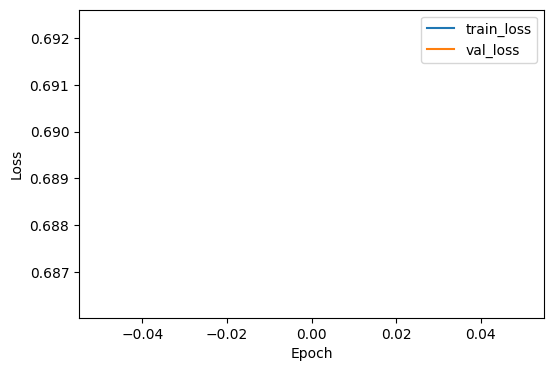

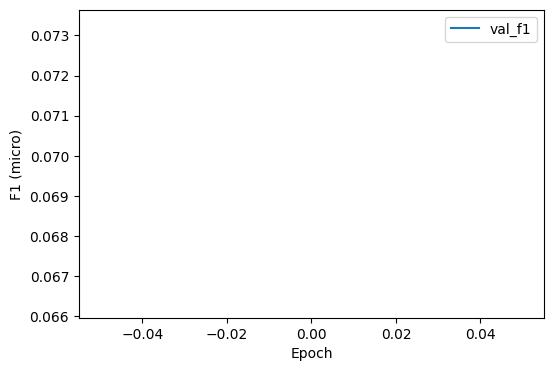

In [43]:
def choose_optimizer(name: str, params, lr: float):
    name = name.lower()
    if name == 'sgd':
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    if name == 'rmsprop':
        return torch.optim.RMSprop(params, lr=lr)
    return torch.optim.Adam(params, lr=lr)

OPTIMIZER_NAME = 'adam'
LR = 1e-3
EPOCHS = 1  # minimal for quick testing
MAX_TRAIN_STEPS = 1  # limit training steps per epoch for fastest smoke test

optimizer = choose_optimizer(OPTIMIZER_NAME, model.parameters(), LR)

def train_epoch(model, loader, criterion, optimizer, device, max_steps=None):
    model.train()
    total_loss = 0.0
    step = 0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        step += 1
        if max_steps is not None and step >= max_steps:
            break
    # avoid divide by zero
    denom = min(len(loader.dataset), step * loader.batch_size) if hasattr(loader, 'dataset') else len(loader)
    denom = denom if denom > 0 else 1
    return total_loss / denom

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item() * xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    return total_loss / len(loader.dataset), all_preds, all_labels

def threshold_outputs(preds, thresh=0.5):
    return (preds >= thresh).astype(int)

best_val_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
BEST_PATH = 'best_model.h5'

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, max_steps=MAX_TRAIN_STEPS)
    val_loss, val_preds, val_labels = eval_epoch(model, val_loader, criterion, device)
    val_bin = threshold_outputs(val_preds)
    val_f1 = f1_score(val_labels, val_bin, average='micro', zero_division=0)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    print(f'Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_f1:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), BEST_PATH)
        print('Saved new best model')

plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['val_f1'], label='val_f1')
plt.xlabel('Epoch')
plt.ylabel('F1 (micro)')
plt.legend()
plt.show()

## 8. Evaluation
Per-class metrics and overall scores; optional confusion matrix.

In [44]:
from pathlib import Path

# Load best model if checkpoint exists (otherwise use current weights)
if Path(BEST_PATH).exists():
    model.load_state_dict(torch.load(BEST_PATH, map_location=device))
    print(f"Loaded checkpoint: {BEST_PATH}")
else:
    print(f"Checkpoint {BEST_PATH} not found. Using current model weights.")

model.to(device)

test_loss, test_preds, test_labels = eval_epoch(model, test_loader, criterion, device)
test_bin = threshold_outputs(test_preds)

overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    test_labels, test_bin, average='micro', zero_division=0
)
overall_acc = accuracy_score(test_labels.flatten(), test_bin.flatten())

print(f"Test loss: {test_loss:.4f}")
print(
    f"Accuracy: {overall_acc:.4f}  Precision: {overall_precision:.4f}  "
    f"Recall: {overall_recall:.4f}  F1: {overall_f1:.4f}"
)

report = classification_report(test_labels, test_bin, target_names=clause_labels, zero_division=0)
print(report)

# Optional: multilabel confusion matrix (sklearn supports per-class)
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, test_bin)
print('Confusion matrix shape:', cm.shape)

Loaded checkpoint: best_model.h5
Test loss: 0.6858
Accuracy: 0.6256  Precision: 0.0304  Recall: 0.3500  F1: 0.0559
                                            precision    recall  f1-score   support

                                   Parties       0.20      0.25      0.22         8
                            Agreement Date       0.10      0.88      0.18         8
                            Effective Date       0.00      0.00      0.00         6
                           Expiration Date       0.09      1.00      0.17         7
                              Renewal Term       0.00      0.00      0.00         1
        Notice Period To Terminate Renewal       0.00      0.00      0.00         0
Notice Period To Terminate Renewal- Answer       0.00      0.00      0.00         0
                             Governing Law       0.09      1.00      0.17         7
                       Most Favored Nation       0.00      0.00      0.00         0
         Competitive Restriction Exception  

## 9. Ablation Setup (Optional)
Compare head-only, tail-only, head–tail, simple truncation.

In [45]:
def make_variant_tokens(text: str, variant: str) -> List[str]:
    toks = simple_word_tokenize(text)
    if variant == 'head':
        return toks[:HEAD_N]
    if variant == 'tail':
        return toks[-TAIL_N:]
    if variant == 'truncate':
        return toks[:MAX_SEQ_WORDS]
    return head_tail_sample(text)

def prepare_variant_df(df_in: pd.DataFrame, variant: str) -> Tuple[pd.DataFrame, Dict[str, int]]:
    df_copy = df_in.copy()
    df_copy['tokens'] = df_copy.text.apply(lambda t: make_variant_tokens(t, variant))
    vocab_var = build_vocab(df_copy.tokens.tolist(), min_freq=VOCAB_MIN_FREQ)
    df_copy['input_ids'] = df_copy.tokens.apply(lambda t: encode_tokens(t, vocab_var, MAX_SEQ_LEN))
    return df_copy, vocab_var

# Example: head-only dataset (demo; re-train with same pipeline for proper comparison)
head_df, head_vocab = prepare_variant_df(df, 'head')
print('Head-only vocab size:', len(head_vocab))

Head-only vocab size: 18969


## 10. Inference on a Sample Contract
Load best checkpoint, run prediction for a single contract string.

In [46]:
def predict_text(text: str, model: nn.Module, vocab: Dict[str, int], threshold: float = 0.5):
    tokens = head_tail_sample(text)
    ids = torch.tensor([encode_tokens(tokens, vocab, MAX_SEQ_LEN)], dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        probs = model(ids).cpu().numpy()[0]
    pred_idxs = [i for i, p in enumerate(probs) if p >= threshold]
    return [(clause_labels[i], probs[i]) for i in pred_idxs]

sample_text = df.iloc[0].text
preds = predict_text(sample_text, model, vocab, threshold=0.5)
print('Predicted clauses:')
for label, prob in preds:
    print(f'{label}: {prob:.3f}')

Predicted clauses:
Agreement Date: 0.505
Expiration Date: 0.509
Notice Period To Terminate Renewal: 0.520
Governing Law: 0.510
Most Favored Nation: 0.502
No-Solicit Of Customers: 0.501
Non-Disparagement: 0.503
Termination For Convenience: 0.504
Price Restrictions: 0.507
Volume Restriction: 0.500
Joint Ip Ownership: 0.510
Source Code Escrow: 0.502
Audit Rights: 0.503
Uncapped Liability: 0.505
Liquidated Damages: 0.513
Covenant Not To Sue: 0.504
Third Party Beneficiary: 0.520
